# En este proyecto intentaremos predecir el género de una película dado el plot en inglés de la misma.

### Carga de datos y limpieza general

Comenzamos importando las librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.utils import shuffle

Descargamos el dataset de Kaggle de este link: https://www.kaggle.com/jrobischon/wikipedia-movie-plots ... Adicionalmente, revisaremos brevemente la información que contiene el DataSet

In [2]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')

In [3]:
display(df.head(2))
display(df.shape)
display(df["Genre"].value_counts().head())
display("Unique genres values: {}".format(len(df["Genre"].value_counts())))

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."


(34886, 8)

unknown    6083
drama      5964
comedy     4379
horror     1167
action     1098
Name: Genre, dtype: int64

'Unique genres values: 2265'

Vemos que hay muchos generos desconocidos y que hay una variedad muy grande de géneros (2265), por ello decido
traerme otro DataFrame de IMDB con los géneros y posteriormente hacer un join. 


In [4]:
# Importamos el nuevo dataframe  
df_genre = pd.read_csv("title.basics.tsv",delimiter="\t")

In [5]:
# Revisamos la información que nos trae el nuevo DataFrame
display(df_genre.head(3))
df_genre.shape

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"


(5463542, 9)

In [6]:
# Hacemos el Merge 
df_joined = df.merge(df_genre[["originalTitle","genres"]],left_on="Title",right_on="originalTitle").sample(80000,random_state=30)


Revisamos la información que tenemos

In [7]:
display("Forma del nuevo df: {}".format(df_joined.shape))

display("Cantidad de películas únicas en el df: {}".format(len(df_joined["Title"].unique().tolist())))

jack = len(df_joined[df_joined["Title"]=="Jack and the Beanstalk"])
display("Hay películas repetidas, por ejemplo, 'Jack and the Beanstalk' aparece {} veces".format(jack))

df_joined[df_joined["Title"] == "Jack and the Beanstalk"][["Title","genres"]].head()

'Forma del nuevo df: (80000, 10)'

'Cantidad de películas únicas en el df: 15451'

"Hay películas repetidas, por ejemplo, 'Jack and the Beanstalk' aparece 23 veces"

,Title,genres
31,Jack and the Beanstalk,"Animation,Comedy,Short"
11,Jack and the Beanstalk,"Animation,Family,Fantasy"
72,Jack and the Beanstalk,"Family,Fantasy,Musical"
81,Jack and the Beanstalk,Family
25,Jack and the Beanstalk,Mystery


In [8]:
# Nos quedamos únicamente con las features que nos interesan.
df_joined_c = df_joined.loc[:,("Title","Plot","genres")]

# Eliminamos las películas que no tienen un género asignado y las filas que están duplicadas.
df_joined_c = df_joined_c[df_joined_c.loc[:,"genres"] !="\\N"]
df_joined_c.drop_duplicates(inplace=True)
display(df_joined_c.shape)
df_joined_c.head(3)

(60982, 3)

,Title,Plot,genres
101523,Best Friends,Richard Babson and Paula McCullen are a couple...,"Comedy,Drama,Fantasy"
153525,Wonderland,The film follows the lives of three London sis...,"Comedy,Short"
121834,Dogfight,The first portion of the film is set on Novemb...,News


Ya que existen películas que aparecen repetidas muchas veces con distintos géneros asignados (como Jack and the Beanstalk), decido quedarme con los dos géneros que más se repiten por pelicula.

In [12]:
new_df = []
def genres(movie):  
    genres = df_joined_c[df_joined_c["Title"]== movie]["genres"].tolist() # List of genres
    title = df_joined_c[df_joined_c["Title"]== movie]["Title"].iloc[0] # title
    plot = df_joined_c[df_joined_c["Title"]== movie]["Plot"].iloc[0] # plot
    list_genres = (",".join(genres)).split(",") # genres in list 
    genres_proc = pd.Series(list_genres).value_counts().index[:2].tolist() # Top 2 most repeated genres
    inf = {"Title":title,"Plot":plot,"Genres":genres_proc} # Final row to add
    new_df.append(inf)

In [13]:
%%time
unique_titles = df_joined_c["Title"].unique().tolist()
for title in unique_titles:
    genres(title)

CPU times: user 8min 8s, sys: 2.86 s, total: 8min 11s
Wall time: 9min 36s


In [14]:
movies = pd.DataFrame(new_df)
movies.head(3)

,Genres,Plot,Title
0,"[Comedy, Drama]",Richard Babson and Paula McCullen are a couple...,Best Friends
1,"[Short, Drama]",The film follows the lives of three London sis...,Wonderland
2,"[Documentary, Short]",The first portion of the film is set on Novemb...,Dogfight


### Análisis sobre los géneros

In [15]:
genres_array = np.array([])
for i in range(0,len(movies)):
    genres_array = np.concatenate((genres_array, movies['Genres'][i]))

In [16]:
# Lets see thow many movies we have for each genre
gen_df = pd.DataFrame({"Genres":genres_array})
gen_df["Count"] = 1 
mbg = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)
mbg.head(10)

,Count
Genres,
Drama,6297
Comedy,4993
Short,2598
Action,2073
Crime,1281
Documentary,1277
Adventure,1104
Romance,909
Thriller,856


Vemos que la mayoría de las películas pertenecen a unos pocos géneros. Así mismo que el género "Music" y "Musical" se puede agrupar. 

In [17]:
# Transformamos "Music" en "Musical"
gen_df["Genres"] = gen_df["Genres"].apply(lambda x: "Musical" if x == "Music" else x)
mbg2 = gen_df.groupby("Genres").sum().sort_values(by="Count",ascending=False)

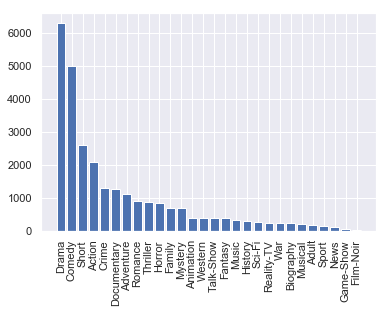

In [18]:
# Creamos un gráfico visual
sns.set()
_ = plt.bar(mbg.index,mbg["Count"],label=mbg.index)
plt.xticks(rotation=90)
plt.show()

In [19]:
# Creamos una tabla de frequencia de distribución para quedarnos con los géneros que incluyen el 95% de los datos.
gen_freq = mbg2.reset_index()
gen_freq["Frequency"] = gen_freq["Count"]/len(gen_df)
gen_freq["Cumulative_Freq"] = gen_freq["Frequency"].cumsum()
gen_freq

,Genres,Count,Frequency,Cumulative_Freq
0,Drama,6297,0.230406,0.230406
1,Comedy,4993,0.182693,0.413099
2,Short,2598,0.095060,0.508160
3,Action,2073,0.075851,0.584010
4,Crime,1281,0.046872,0.630882
5,Documentary,1277,0.046725,0.677607
6,Adventure,1104,0.040395,0.718002
7,Romance,909,0.033260,0.751262
8,Thriller,856,0.031321,0.782583
9,Horror,832,0.030443,0.813026


Ya que conocemos los géneros principales, filtremos nuestro dataframe original. Recordemos que debemos también
sustituir "Music" por "Musical" en nuestos datos originales. En un primer intento de la clasificacion de los generos con los algoritmos de sklearn, ocurre que me está clasificando todas las películas como Drama o como Comedia, es por ello que vamos a disminuir la cantidad de películas seleccionadas de esos géneros para quitarles preponderancia. Adicionalmente, decido eliminar el genero "Short" ya que analizando sus plots no hay nada que los distinga del resto de los generos y esto puede disminuir la precision del modelo.

In [20]:
# Preparamos un listado de los generos que contienen el 85% de los datos y que son distintos a "Short".
top_genres = np.array(gen_freq[(gen_freq["Cumulative_Freq"]<=0.85) & ( gen_freq["Genres"]!= "Short")]["Genres"])

In [21]:
# Cambiamos music por musical y Filtramos los generos que incluyen el 85% de los datos.

movies["Genres"] = movies["Genres"].apply(lambda x: ["Musical" if word =="Music" else word for word in x])
movies["Main_Genres"] = movies["Genres"].apply(lambda x: np.array(x)[np.in1d(x,top_genres)])
movies_filtered = (movies[movies["Main_Genres"].str.len() != 0])
movies_cleaned = movies_filtered[["Plot","Main_Genres"]]

movies_cleaned.head(2)

,Plot,Main_Genres
0,Richard Babson and Paula McCullen are a couple...,"[Comedy, Drama]"
1,The film follows the lives of three London sis...,[Drama]


In [22]:
# Pasamos los generos a OneHotEncoding
movies_filtered_genres = movies_filtered[["Main_Genres","Plot"]]
movie_filt = movies_filtered_genres["Main_Genres"].apply(lambda x: ",".join(x))
movies_cleaned = pd.concat([movies_cleaned,movie_filt.str.get_dummies(sep=",")],axis=1)

In [23]:
# Balanceamos la cantidad de películas que seleccionaremos por género

movie_expanded = movie_filt.str.split(",",expand=True)
movie_concat = pd.concat([movie_expanded.iloc[:,0],movie_expanded.iloc[:,1]],axis=0)
max_cantidad = movie_concat.dropna().value_counts().min()

new_movies = pd.DataFrame()

for genre in top_genres:
    filtrado_por_genero = movies_cleaned[movies_cleaned[genre]==1]
    genero = (filtrado_por_genero.sample(min(len(filtrado_por_genero),int(max_cantidad)),random_state=30))
    new_movies = new_movies.append(genero)

Text(0.5, 1.0, 'Amount of movies per genre')

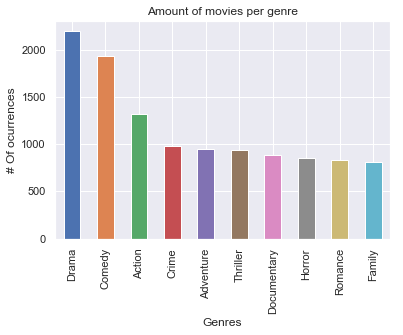

In [24]:
# Visualizamos la cantidad de películas que tenemos por género, vemos que está más balanceado.
new_movies = new_movies.dropna()
new_movies_calc = new_movies.drop(["Plot","Main_Genres"],axis=1)
nuevos_generos = {}

for genre in new_movies_calc.columns.tolist():
    nuevos_generos[genre]= (new_movies_calc[genre]==1).sum()
    
nuevas_cant = pd.Series(nuevos_generos)
sns.set()
nuevas_cant.sort_values(ascending=False).plot(kind="bar",legend=False)
plt.xlabel("Genres")
plt.ylabel("# Of ocurrences")
plt.title("Amount of movies per genre")

In [25]:
movies_cleaned = new_movies.drop("Main_Genres",axis=1)

### Limpieza de los plots

Comenzamos por crear una serie de funciones que nos permitirán limpiar los plots. Lemmatize convierte distintas palabras de igual significado en la misma, luego las regular expressions y RemoveCharDigit se quedan solo con palabras eliminando números y caractéres especiales, así como conviertiendo palabras compuestas en palabras separadas. 

In [26]:
stop_words = stopwords.words("english")
Stop_word_TryAndError = ["ha","wa","one","get","take","go","back","tell","two","make","see","come","hi","tri","him",'thi',"onli","him","also","later"]
lemma=WordNetLemmatizer()
token=ToktokTokenizer()
stemmer = PorterStemmer()

In [27]:
def lemitizeWords(text):
    listLemma = []
    words=token.tokenize(text)
    stem = [stemmer.stem(word) for word in words]
    for w in stem:
        x=lemma.lemmatize(w)
        listLemma.append(x)
    return listLemma

def stopWordsRemove(text):
    wordList =[x.lower().strip() for x in token.tokenize(text)]
    removedList=[x for x in wordList if x not in stop_words and x not in Stop_word_TryAndError]
    text=" ".join(removedList)
    return text

def removeCharDigit(text):
    str="1234567890-=~@#$%^&*()_+[!{;”:\’><.,/?”}]"
    for w in text:
        if w in str:
            text=text.replace(w,"")
    return text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def PreProcessing(text):
    text = lemitizeWords(text)
    text = stopWordsRemove(text)
    text = clean_text(text)
    text = removeCharDigit(text)   
    return(text)

def preprocessing2(x):
    alo = nltk.FreqDist([word for word in x.split()]).most_common(120)
    return " ".join([ word[0] for word in alo])

In [28]:
ejemplo = " ".join(movies_cleaned[["Plot"]].iloc[3].tolist())
print("Por ejemplo, la frase: {}".format(ejemplo))
print("\nSe convierte en:")
print("\n{}".format(preprocessing2(PreProcessing(ejemplo))))

Por ejemplo, la frase: At an elite school, a group of students who call themselves The Sentinels begin terrorizing their socially undesirable classmates. Soon, one of their targets ends up brutally murdered. An editor of the high school paper begins to investigate and The Sentinels become even more ruthless in their behavior.

Se convierte en:

school sentinel begin elit group student call themselv terror social undesir classmates soon target end brutal murdered editor high paper investig becom even ruthless behavior


In [29]:
# Apliquemos la funcion a todos los plots. 
movies_cleaned["plot_cleaned"] = movies_cleaned["Plot"].apply(lambda x : PreProcessing(x)).apply(lambda x: preprocessing2(x))

### Análisis de las palabras de los plots 

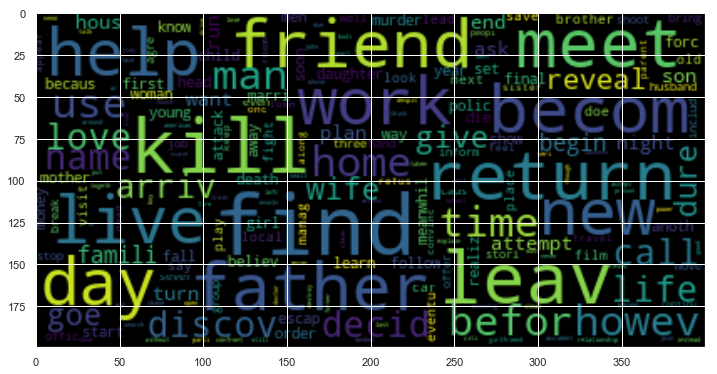

In [30]:
totalText=""
for words in movies_cleaned["plot_cleaned"]:
    totalText += words

wc=WordCloud(background_color="black",max_font_size=50).generate(totalText)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")

### Frecuencia con la que aparecen las palabras 

Text(0.5, 1.0, 'Most frequent Words')

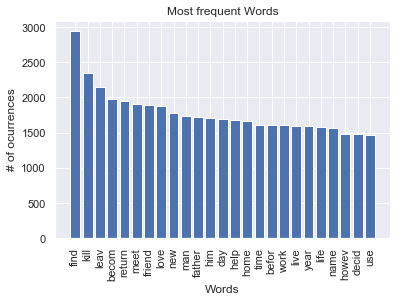

In [31]:
x=nltk.FreqDist(ToktokTokenizer().tokenize(totalText)).most_common(25)
words = [words[0] for words in x]
values = [values[1] for values in x]

_= plt.bar(words,values)
_ = plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("# of ocurrences")
plt.title("Most frequent Words")

Modifiquemos las palabras con one hot encoding, para ello utilizamos CountVectorier y TfidfTransformer

In [32]:
movies_cleaned.dropna(inplace=True)

### Clasificacion - Entrenamiento y prueba de modelos 

In [33]:
X = movies_cleaned["plot_cleaned"]
y = movies_cleaned.drop(["Plot","plot_cleaned"],axis=1)

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5235,), (1745,), (5235, 10), (1745, 10))

In [35]:
LogReg_pipeline = Pipeline([
                 ('tfidf', TfidfVectorizer()),
                 ('clf', OneVsRestClassifier(LogisticRegression()))],
                  )
for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))

... Processing Action
Test accuracy is 0.8143266475644699
[[1412    3]
 [ 321    9]]
... Processing Adventure
Test accuracy is 0.8744985673352436
[[1521    0]
 [ 219    5]]
... Processing Comedy
Test accuracy is 0.7289398280802293
[[1226    7]
 [ 466   46]]
... Processing Crime
Test accuracy is 0.8601719197707737
[[1497    3]
 [ 241    4]]
... Processing Documentary
Test accuracy is 0.8785100286532951
[[1533    0]
 [ 212    0]]
... Processing Drama
Test accuracy is 0.7020057306590258
[[1150   35]
 [ 485   75]]
... Processing Family
Test accuracy is 0.8744985673352436
[[1525    0]
 [ 219    1]]
... Processing Horror
Test accuracy is 0.8825214899713467
[[1535    4]
 [ 201    5]]
... Processing Romance
Test accuracy is 0.8756446991404011
[[1526    0]
 [ 217    2]]
... Processing Thriller
Test accuracy is 0.8813753581661891
[[1538    0]
 [ 207    0]]


In [36]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
            ])

for genre in np.array(y.columns):
    print('... Processing {}'.format(genre))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, y_train[genre])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[genre], prediction)))
    print(confusion_matrix(y_test[genre], prediction))

... Processing Action
Test accuracy is 0.8521489971346705
[[1371   44]
 [ 214  116]]
... Processing Adventure
Test accuracy is 0.9002865329512894
[[1496   25]
 [ 149   75]]
... Processing Comedy
Test accuracy is 0.7386819484240688
[[1116  117]
 [ 339  173]]
... Processing Crime
Test accuracy is 0.8957020057306591
[[1468   32]
 [ 150   95]]
... Processing Documentary
Test accuracy is 0.8911174785100286
[[1526    7]
 [ 183   29]]
... Processing Drama
Test accuracy is 0.7214899713467049
[[1023  162]
 [ 324  236]]
... Processing Family
Test accuracy is 0.9117478510028654
[[1520    5]
 [ 149   71]]
... Processing Horror
Test accuracy is 0.9209169054441261
[[1516   23]
 [ 115   91]]
... Processing Romance
Test accuracy is 0.898567335243553
[[1507   19]
 [ 158   61]]
... Processing Thriller
Test accuracy is 0.9094555873925502
[[1521   17]
 [ 141   66]]


In [37]:
SVC_pipeline.fit(X_train,y_train)
predictions = SVC_pipeline.predict(X_test)
cm = confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

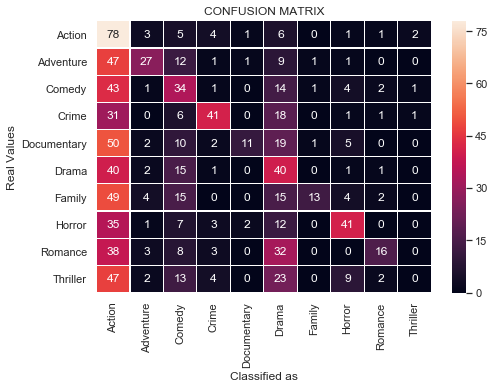

In [38]:
def confusionMatrixHeatmap(cm, labels):
    totals = cm.sum(axis=1)
    cm_total = (np.ones(cm.shape)*totals).transpose()
    m2 = np.round(((cm/cm_total)*100).astype(float))
    np.set_printoptions(precision=2)
    f, ax=plt.subplots(figsize=(7.5,5))
    sns.heatmap(m2, annot=True, linecolor='white', linewidths=0.2,
                xticklabels=labels, yticklabels=labels)
    ax.set_title('CONFUSION MATRIX')
    plt.xlabel('Classified as')
    plt.ylabel('Real Values')
    
cm2 = confusionMatrixHeatmap(cm,y.columns)
cm2